In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data import Dataset
from torch.nn.utils import weight_norm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sentencepiece as spm

base_dir = '/content/drive/MyDrive/Data_set'

-----------------------------------------

# Processing raw data

In [ ]:
!pip install translate

In [ ]:
raw_data=[]
path = '/content/drive/MyDrive/Data_set/raw2.txt'
a='abcdefghijklmnopqrstuvwxyz'
A='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
mark='.?!'

with open(path, 'r') as file:
    for line in file:
        if len(line) < 1:
            continue
        sentence =''
        for i in range(len(line)):
            if  line[i]in mark:
                sentence+=' '
                sentence+=line[i]
                raw_data.append(sentence)
                sentence =''
            elif line[i] in a and line[i+1] in A:
                sentence+=line[i]
                sentence+=' .'
                raw_data.append(sentence)
                sentence =''
            elif line[i] =='\n':
                raw_data.append(sentence)
                sentence =''
            else:
                sentence+=line[i]
        raw_data.append(sentence)


In [ ]:
processed_data=[]
for i in raw_data:
    if not (i == '' or i==' .'):
        if i[0]==' ':
            processed_data.append(i[1:])
            continue
        processed_data.append(i)

In [ ]:
dummy = []
for i in  processed_data:
    if len(i)> 3 and i [0] in A:
        i = a[A.index(i[0])] + i[1:]
    dummy.append(i.split(' '))
for i in  dummy:
    if len(i)< 3:
        dummy.remove(i)

In [ ]:
dummy = [i for n, i in enumerate(dummy) if i not in dummy[:n]]

In [ ]:
processed_data=dummy

In [ ]:
len(dummy)

In [ ]:
filename = '/content/drive/MyDrive/Data_set/vn_processed1.txt'
with open(filename, 'w') as file:
        for data in processed_data:
        # Writing to a file

            file.write(" ".join(map(str, data)))
            file.write("\n")

translate to VN  for trainning

In [ ]:
from translate import Translator
translator = Translator(to_lang="vi")
translation = translator.translate("This is a pen .")
print(translation)

In [ ]:
array=[]
with open('/content/drive/MyDrive/Data_set/vn_processed1.txt', 'r') as file:
    for line in file:
        translation = translator.translate(line)
        array.append(translation)

with open('/content/drive/MyDrive/Data_set/en_processed1.txt', 'w') as file:
    for data in array:

        file.write(data)
        file.write("\n")


# Train tokenizer

In [ ]:
!pip install sentencepiece

In [ ]:



input_file_vn = os.path.join(base_dir, 'vn_processed.txt')
input_file_en = os.path.join(base_dir, 'en_processed.txt')

# Set the desired vocabulary sizes
target_vocab_size_vn = 400
target_vocab_size_en = 600

# Train the SentencePiece model for English
spm.SentencePieceTrainer.Train(
    f"--input={input_file_vn} --model_type=unigram --hard_vocab_limit=false" +
    f" --model_prefix={base_dir}/en --vocab_size={target_vocab_size_vn}")

# Train the SentencePiece model for VietNamese
spm.SentencePieceTrainer.Train(
    f"--input={input_file_en} --model_type=unigram --hard_vocab_limit=false" +
    f" --model_prefix={base_dir}/vn --vocab_size={target_vocab_size_en}")

print("SentencePiece model training complete.")


#  processing trainning data

dataset : vn_processed.txt , en_processed.txt
(self collected) , 1103 senctence that match each other from eng to vn

## functions

In [ ]:
def load_data_files(folder_path):
    data_set = []
    with open(folder_path, 'r') as file:
        for line in file:
            data_set.append(line)
    return data_set


def pad_sequences(sequences, maxlen, padding_value):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < maxlen:
            seq = seq + [padding_value] * (maxlen - len(seq))
        padded_sequences.append(seq)
    return torch.tensor(padded_sequences)

##exercution

In [ ]:
vn_text = load_data_files(os.path.join(base_dir, 'vn_processed.txt'))
en_text = load_data_files(os.path.join(base_dir, 'en_processed.txt'))

train_vn_X = []
train_en_X = []
train_en_Y = []

vn_max_len = 0
en_max_len = 0

sp_vn = spm.SentencePieceProcessor()
sp_vn.Load(os.path.join(base_dir,'en.model'))

sp_en = spm.SentencePieceProcessor()
sp_en.Load(os.path.join(base_dir,'vn.model'))

vocab_size_vn = sp_vn.GetPieceSize()
vocab_size_en = sp_en.GetPieceSize()
# Assuming three extra tokens: <end>: #vocab_size_vn | #vocab_size_en,
# <empty>: #vocab_size_vn+1 | #vocab_size_en+1, and <start>: #vocab_size_en+2
end_tokvn_id_vn = vocab_size_vn
empty_tokvn_id_vn = vocab_size_vn + 1
end_tokvn_id_en = vocab_size_en
empty_tokvn_id_en = vocab_size_en + 1
start_tokvn_id_en = vocab_size_en + 2

# The input text only needs two extra tokens while the output needs 3
vocab_size_vn += 2
vocab_size_en += 3

for i in range(len(vn_text)):
    vn_seq = sp_vn.EncodeAsIds(vn_text[i].strip()) + [end_tokvn_id_vn]
    vn_max_len = max(vn_max_len, len(vn_seq))
    train_vn_X.append(vn_seq)

    en_seq = sp_en.EncodeAsIds(en_text[i].strip()) + [end_tokvn_id_en]
    en_max_len = max(en_max_len, len(en_seq))
    train_en_X.append(en_seq)

# Padding all the samples with <empty> token to make them all of the same length
train_vn_X = pad_sequences(train_vn_X, maxlen=en_max_len + 1, padding_value=empty_tokvn_id_vn)
train_en_X = pad_sequences(train_en_X, maxlen=en_max_len + 1, padding_value=empty_tokvn_id_en)

# Converting the train_en_Y to a one-hot vector needed by the training phase as the output
def to_categorical(y, num_classes):
    return F.one_hot(y, num_classes=num_classes).float()

train_en_Y = to_categorical(train_en_X, num_classes=vocab_size_en)

# Moving the last <empty> to the first position in each input sample
train_en_X = torch.roll(train_en_X, 1, dims=-1)
# Changing the first token in each input sample to <start>
train_en_X[:, 0] = start_tokvn_id_en

en_max_len += 1


# defining model

## for trainning

In [ ]:

class LSTM_vncode_decode_Model(nn.Module):
    def __init__(self, vocab_size_vn, vocab_size_en, hiddvn_dim, vn_max_len, att=False):
        super(LSTM_vncode_decode_Model, self).__init__()
        self.hiddvn_dim = hiddvn_dim
        self.att=att
        self.embedding_vn = nn.Embedding(vocab_size_vn, hiddvn_dim)
        self.embedding_en = nn.Embedding(vocab_size_en, hiddvn_dim)
        self.encoder_lstm = nn.LSTM(hiddvn_dim, hiddvn_dim, bidirectional=True, batch_first=True)
        self.decoder_lstm = nn.LSTM(hiddvn_dim , hiddvn_dim * 2, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hiddvn_dim * 2,
                                               num_heads=1,
                                               batch_first=True)
        #self.fc1 = nn.Linear(hiddvn_dim * 4, 2048)
        self.fc1 = nn.Linear(hiddvn_dim * 2 if not att else hiddvn_dim * 4, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, vocab_size_en)
        self.dropout = nn.Dropout(0.4)

    def forward(self, input_vn, input_en):
        embedded_vn = self.embedding_vn(input_vn)
        encoder_outputs, (hidden, cell) = self.encoder_lstm(embedded_vn)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        cell = torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)

        embedded_en = self.embedding_en(input_en)
        decoder_outputs, _ = self.decoder_lstm(embedded_en, (hidden.unsqueeze(0), cell.unsqueeze(0)))
        if self.att:
            context, _ = self.attention(decoder_outputs, encoder_outputs, encoder_outputs)
            rnn_output = torch.cat((decoder_outputs, context.expand(decoder_outputs.shape[0], decoder_outputs.shape[1], -1)), dim=2)
        else:
            rnn_output = decoder_outputs
            #rnn_output = rnn_output.contiguous().view(-1, rnn_output.shape[2])

        dl0 = torch.relu(self.fc1(rnn_output))
        dl1 = torch.relu(self.fc2(dl0))
        dl2 = torch.relu(self.fc3(dl1))
        dl2 = self.dropout(dl2)
        #dense_output = torch.softmax(self.fc4(dl2), dim=-1)
        dense_output = torch.sigmoid(self.fc4(dl2))
        dense_output = dense_output.view(input_en.size(0), input_en.size(1), -1)
        return dense_output



In [ ]:
hiddvn_dim=128
model_non_att = LSTM_vncode_decode_Model(vocab_size_vn, vocab_size_en, hiddvn_dim, vn_max_len)
model_att = LSTM_vncode_decode_Model(vocab_size_vn, vocab_size_en, hiddvn_dim, vn_max_len, att=True)
model_att

LSTM_encode_decode_Model(
  (embedding_en): Embedding(402, 128)
  (embedding_vn): Embedding(603, 128)
  (encoder_lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (decoder_lstm): LSTM(128, 256, batch_first=True)
  (attention): AttentionLayer(
    (attn): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=603, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

##for testing

In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size_vn, hiddvn_dim):
        super(Encoder, self).__init__()
        self.embedding_vn = nn.Embedding(vocab_size_vn, hiddvn_dim)
        self.encoder_lstm = nn.LSTM(hiddvn_dim, hiddvn_dim, bidirectional=True, batch_first=True)

    def forward(self, input_vn):
        embedded_vn = self.embedding_vn(input_vn)
        encoder_outputs, (hidden, cell) = self.encoder_lstm(embedded_vn)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        cell = torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)
        return encoder_outputs, hidden, cell

class AttentionLayer(nn.Module):
    def __init__(self, hiddvn_dim):
        super(AttentionLayer, self).__init__()
        self.attn = nn.Linear(hiddvn_dim * 4, hiddvn_dim * 2)
        self.v = nn.Parameter(torch.rand(hiddvn_dim * 2))

    def forward(self, encoder_outputs, decoder_hidden):
        seq_len, batch_size, hiddvn_dim = encoder_outputs.shape
        decoder_hiddvn_expanded = decoder_hidden.unsqueeze(1).expand(-1, seq_len, -1)
        combined = torch.cat((encoder_outputs, decoder_hiddvn_expanded), dim=2)
        attn_weights = torch.sum(self.v * torch.tanh(self.attn(combined)), dim=2)
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(attn_weights.unsqueeze(2) * encoder_outputs, dim=1)
        return context, attn_weights

class Decoder(nn.Module):
    def __init__(self, vocab_size_en, hiddvn_dim, output_dim):
        super(Decoder, self).__init__()
        self.embedding_en = nn.Embedding(vocab_size_en, hiddvn_dim)
        self.decoder_lstm = nn.LSTM(hiddvn_dim, hiddvn_dim * 2, batch_first=True)
        self.attention = AttentionLayer(hiddvn_dim)
        self.fc1 = nn.Linear(hiddvn_dim * 4, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, input_en, hidden, cell, encoder_outputs):
        embedded_en = self.embedding_en(input_en)
        decoder_outputs, (hidden, cell) = self.decoder_lstm(embedded_en, (hidden.unsqueeze(0), cell.unsqueeze(0)))

        context, _ = self.attention(encoder_outputs, decoder_outputs[:, -1, :])
        rnn_output = torch.cat((decoder_outputs, context.unsqueeze(1).expand_as(decoder_outputs)), dim=2)

        dl0 = torch.relu(self.fc1(rnn_output))
        dl1 = torch.relu(self.fc2(dl0))
        dl2 = torch.relu(self.fc3(dl1))
        dl2 = self.dropout(dl2)
        dense_output = torch.sigmoid(self.fc4(dl2))  # Use sigmoid activation for binary output

        return dense_output, hidden, cell





In [ ]:

input_dim = vocab_size_vn  # Input dimension
encoder_model = Encoder(vocab_size_vn, hiddvn_dim)
decoder_model = Decoder(vocab_size_en, hiddvn_dim, vocab_size_en)

print(encoder_model)
print(decoder_model)

Encoder(
  (embedding_en): Embedding(402, 128)
  (encoder_lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
)
Decoder(
  (embedding_vn): Embedding(603, 128)
  (decoder_lstm): LSTM(128, 256, batch_first=True)
  (attention): AttentionLayer(
    (attn): Linear(in_features=512, out_features=256, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=603, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


#Training

##functions

In [ ]:
def save_checkpoint(model, epoch, optimizer, loss, filepath):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, filepath)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, file):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    lost_o_time=[]
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for vn_input, en_input, en_target in train_loader:
            vn_input, en_input, en_target = vn_input.to(device), en_input.to(device), en_target.to(device)
            optimizer.zero_grad()
            output = model(vn_input, en_input)
            loss = criterion(output.view(-1, output.shape[-1]), en_target.view(-1, en_target.shape[-1]))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        val_loss = evaluate_model(model, val_loader, criterion, device)

        checkpoint_path = os.path.join(base_dir, file)
        save_checkpoint(model, epoch+1, optimizer, val_loss, checkpoint_path)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        lost_o_time.append((train_loss,val_loss))
    return lost_o_time

def evaluate_model(model, val_loader, criterion , device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for vn_input, en_input, en_target in val_loader:
            vn_input, en_input, en_target = vn_input.to(device), en_input.to(device), en_target.to(device)
            output = model(vn_input, en_input)
            loss = criterion(output.view(-1, output.shape[-1]), en_target.view(-1, en_target.shape[-1]))
            val_loss += loss.item()
    return val_loss / len(val_loader)

def load_checkpoint(filepath, model, optimizer=None):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss




##exercution

In [ ]:
hiddvn_dim=128
model_non_att = LSTM_vncode_decode_Model(vocab_size_vn, vocab_size_en, hiddvn_dim, vn_max_len)
model_att = LSTM_vncode_decode_Model(vocab_size_vn, vocab_size_en, hiddvn_dim, vn_max_len, att=True)
# Data loading
batch_size = 100
epochs = 5
validation_split = 0.3
dataset = TensorDataset(train_vn_X, train_en_X, train_en_Y)
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model, criterion, optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_att.parameters())

checkpoint_att =  f'att.pt'
checkpoint_non_att = f'non_att.pt'




In [ ]:
# Train the model
loss = train_model(model_att, train_loader, val_loader, criterion, optimizer, epochs=epochs, file=checkpoint_att)

Epoch 1/5, Train Loss: 0.8319, Val Loss: 0.6931
Epoch 2/5, Train Loss: 0.6931, Val Loss: 0.6930
Epoch 3/5, Train Loss: 0.6930, Val Loss: 0.6930
Epoch 4/5, Train Loss: 0.6930, Val Loss: 0.6930
Epoch 5/5, Train Loss: 0.6930, Val Loss: 0.6930


In [ ]:
loss2 = train_model(model_non_att, train_loader, val_loader, criterion, optimizer, epochs=epochs, file=checkpoint_non_att)

Epoch 1/5, Train Loss: 0.9733, Val Loss: 0.9733
Epoch 2/5, Train Loss: 0.9733, Val Loss: 0.9733
Epoch 3/5, Train Loss: 0.9733, Val Loss: 0.9733
Epoch 4/5, Train Loss: 0.9733, Val Loss: 0.9733
Epoch 5/5, Train Loss: 0.9733, Val Loss: 0.9733


In [ ]:
#load train process
model_att, optimizer, epoch, loss = load_checkpoint(checkpoint_att, model_att, optimizer)
print(f"Model loaded from epoch {epoch}, with validation loss of {loss:.4f}")


compare loss

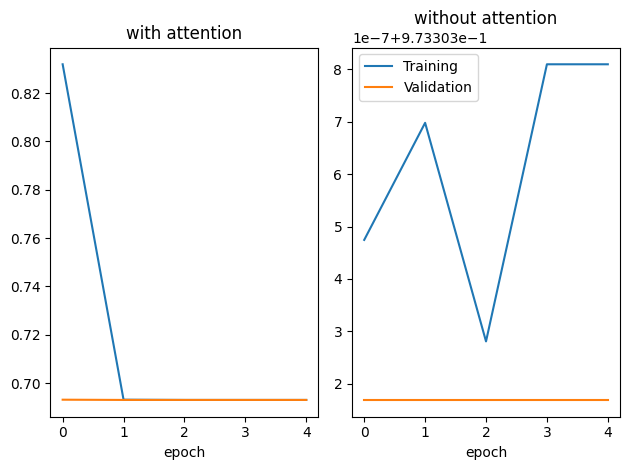

In [ ]:
import matplotlib.pyplot as plt

tra_loss = [i[0] for i in loss]
val_loss = [i[1] for i in loss]
tra_loss2 = [i[0] for i in loss2]
val_loss2 = [i[1] for i in loss2]

plt.subplot(1, 2, 1)
plt.plot(range(epochs), tra_loss, label = "Training")
plt.plot(range(epochs), val_loss, label = "Validation")
plt.xlabel('epoch')
plt.title('with attention')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), tra_loss2, label = "Training")
plt.plot(range(epochs), val_loss2, label = "Validation")
plt.xlabel('epoch')
plt.title('without attention')

plt.legend()

plt.tight_layout()

plt.show()

#evaluation